In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG
import numpy as np
torch.set_default_dtype(torch.float64)

# Setup

In [3]:
from FittedModels.Utils.analysis_utils import estimate_key_info

In [82]:
def get_vars(hist_list, index2=0):
    index1 = 0 # second axis has no var
    return [np.var(run_list, axis=0, ddof=1)[index1, index2] for run_list in hist_list]

In [83]:
def get_means(hist_list, index2=0):
    index1 = 0 # second axis has no var
    return [np.mean(run_list, axis=0)[index1, index2] for run_list in hist_list]

In [84]:
def get_SNR(hist_list, index2=0):
    index1 = 0 # second axis has no var
    return [np.abs(np.mean(run_list, axis=0)[index1, index2])/np.std(run_list, axis=0, ddof=1)[index1, index2] for run_list in hist_list]

In [85]:
def get_coeff_of_variation(hist_list, index2=0):
    index1 = 0 # second axis has no var
    return [np.std(run_list, axis=0, ddof=1)[index1, index2]/np.abs(np.mean(run_list, axis=0)[index1, index2]) for run_list in hist_list]

# Easy problem

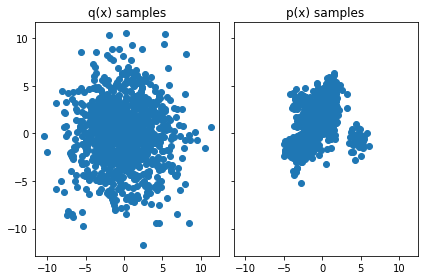

In [7]:
torch.manual_seed(0) 
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=2, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [8]:
alpha_2_grads_1_list, alpha_2_grads_2_list, kl_DReG_grads_1_list, \
           kl_DReG_grads_2_list, kl_grads_1_list, kl_grads_2_list, \
            n_points_space = \
                    estimate_key_info(tester, max_n_samples=1e4, min_n_samples=100, n_runs_max=10)

100%|██████████| 3/3 [02:14<00:00, 44.97s/it] 


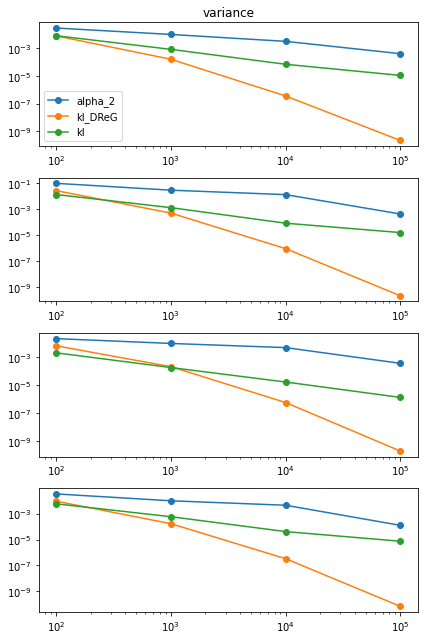

In [86]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("variance")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_vars(alpha_2_grads_1_list, i), "o-", label="alpha_2")
    axs[i].plot(n_points_space, get_vars(kl_DReG_grads_1_list, i), "o-", label="kl_DReG")
    axs[i].plot(n_points_space, get_vars(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()

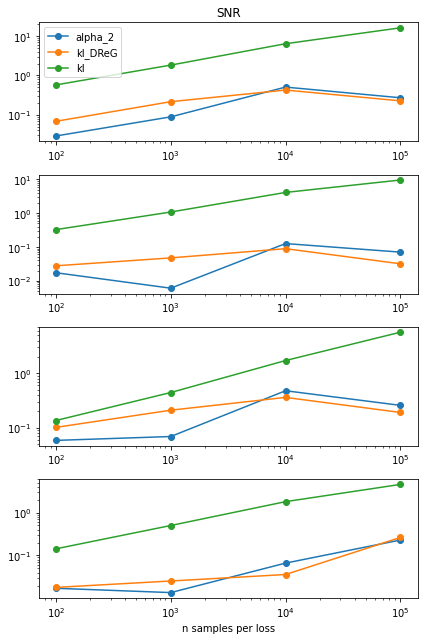

In [90]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("SNR")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_SNR(alpha_2_grads_1_list, i), "o-", label="alpha_2")
    axs[i].plot(n_points_space, get_SNR(kl_DReG_grads_1_list, i), "o-", label="kl_DReG")
    axs[i].plot(n_points_space, get_SNR(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()

# Harder Problem

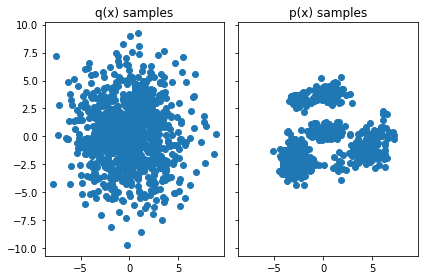

In [58]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
dim = 3
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [79]:
alpha_2_grads_1_list, alpha_2_grads_2_list, kl_DReG_grads_1_list, \
           kl_DReG_grads_2_list, kl_grads_1_list, kl_grads_2_list, \
            n_points_space = \
                    estimate_key_info(tester, max_n_samples=1e5, min_n_samples=100, n_runs_max=10)

100%|██████████| 4/4 [29:50<00:00, 447.62s/it]   


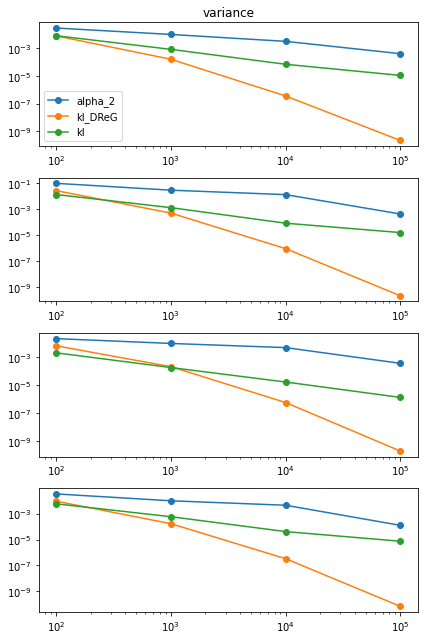

In [86]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("variance")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_vars(alpha_2_grads_1_list, i), "o-", label="alpha_2")
    axs[i].plot(n_points_space, get_vars(kl_DReG_grads_1_list, i), "o-", label="kl_DReG")
    axs[i].plot(n_points_space, get_vars(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()

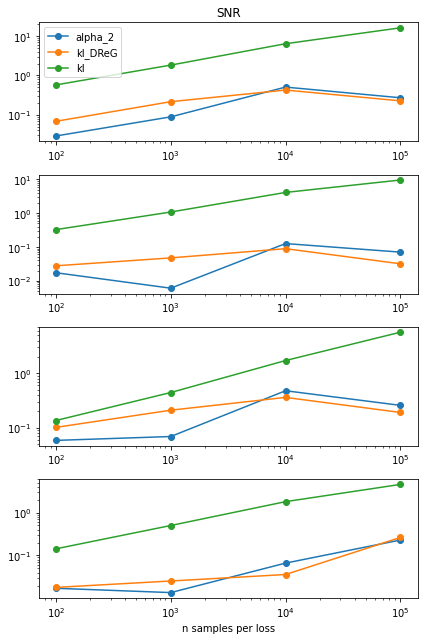

In [90]:
n_indexes = 4
fig, axs = plt.subplots(n_indexes,1, figsize=(6, 9))
axs[0].set_title("SNR")
axs[-1].set_xlabel("n samples per loss")
for i in range(n_indexes):
    axs[i].plot(n_points_space, get_SNR(alpha_2_grads_1_list, i), "o-", label="alpha_2")
    axs[i].plot(n_points_space, get_SNR(kl_DReG_grads_1_list, i), "o-", label="kl_DReG")
    axs[i].plot(n_points_space, get_SNR(kl_grads_1_list, i), "o-", label="kl")
    axs[i].set_xscale("log")
    axs[i].set_yscale("log")
    if i == 0:
        axs[i].legend()
plt.tight_layout()

# Harder harder Problem

In [ ]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
dim = 6
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [ ]:
kl_hist, alpha_2_hist, n_points_space = estimate_key_info(tester, int(1e6), min_n_samples=100)

In [ ]:
plt.figure()
plt.plot(n_points_space, get_vars(kl_hist), "o-")
plt.xscale("log")
plt.title("kl estimate variance")
plt.figure()
plt.plot(n_points_space, get_vars(alpha_2_hist), "o-")
plt.title("alpha_2 divergence estimate variance")
plt.xscale("log")

In [ ]:
plt.figure()
plt.plot(n_points_space, get_means(kl_hist), "o-")
plt.xscale("log")
plt.title("kl estimate mean")
plt.figure()
plt.plot(n_points_space, get_means(alpha_2_hist), "o-")
plt.title("alpha_2 divergence estimate mean")
plt.xscale("log")

In [ ]:
plt.figure()
plt.plot(n_points_space, get_coeff_of_variation(kl_hist), "o-")
plt.xscale("log")
plt.title("kl estimate coefficient of variation")
plt.figure()
plt.plot(n_points_space, get_coeff_of_variation(alpha_2_hist), "o-")
plt.title("alpha_2 divergence estimate coefficient of variation")
plt.xscale("log")